Mary Jane the Model
==============

***Using machine earning to reveal insights and predict performance of cannabis dispensaries***

**Author:** *Scott Butters*

# Abstract

In 2012, Washington state passed I-502 and legalized the recreational sale, use, and possession of marijuana. This event has led to an explosion of development in the field that's making waves through our society. Since 2014, approximately 500 state licensed dispensaries have opened throughout the state, with nearly 150 of those here in Seattle. And the thing that gets me excited is that because of regulations, a ton of their data is publicly available, meaning I got to play with it. We can go into the weeds later about how and why it took me a thousand websites and 4 different scraping techniques to get the data, and how my R^2 varied when I went shifted from 10-30 features to estimate the monthly revenue of a cannabis dispensary. But for now, let me tell you about what I learned as I immersed myself in this dataset over the past 2 weeks. In this project I scour the web for publicly available data that might be predictive of how a cannabis dispensary performs, such as customer reviews, inventory distributions, and local demographics. I then train machine learning models to predict a dispensary's monthly revenue and analyze the resulting models to distill insights about what drives sales in the marijuana market.


In this project, I explored the question of what makes the Washington recreational cannabis market tick. I decided that if I could identify the features that most contributed to a dispensary's revenue, I could get a lot of insight out of how the features shake out. 

When asked what my project was, I kept saying that it was to use web scraping to predict monthly revenue using linear regression. And it was, of course it was. But that's not the point, that's not the story. 

Here's the monthly revenue of all dispensaries for the last 16 months. See the trend?

Okay. Now. Here's the monthly revenue of a handful of dispensaries over that same period. See the trend?

But we can show this better. Here's the average monthly change in revenue of a dispensary.
Next to the change for the overall market. 
Next to variation in the S&P 500 over the same period.
And now the top marijuana ETF out there.

So if we're going to make choices about what to invest in to make a dispensary successful, we need to have the impacts of the external market in context. So I put those indicators in there for some regression models to see how significant a role they played.

In at attempt to both have more data and isolate the time component of my analysis, I constructed a new target variable, which is marketshare. For each month, I divided the revenue of a given dispensary by the revenue of all of the dispensaries over that period. 

# Obtain the Data

The data for this project is derived from several sources:

## Dispensary profiles from [Leafly](www.leafly.com)

Leafly is an information aggregator for cannabis. They maintain a profile for most of the dispensaries in the state. As part of my dataset, I've scraped the following features from the Leafly website for each dispensary for which it was available:

* Average customer rating and number of customer reviews
* Inventory counts (number of products under descriptions like "flower", "edibles", "concentrates", etc.
* Categorical qualities, such as whether or not the store is ADA accessible or has an ATM onsite
* Metadata such as name, address, phone number, etc.

The combination of these features gives us a profile of each dispensary that allow us to draw insights from our model into what makes for a successful dispensary.

## Demographics from [WA HomeTownLocator](https://washington.hometownlocator.com/)

Of course, having the best inventory, friendliest staff and prettiest building in the state doesn't amount to anything if a dispensary is in the middle of nowhere. This is where demographic data comes in. WA HomeTownLocator maintains a database of demographic statistics for nearly every zip code in the state of Washington. The data is produced by Esri Demographics, and updated 4 times per year using data from the federal census, IRS, USPS, as well as local data sources and more. From this website I scraped data likely to be predictive of a local market such as:

* Population density
* Diversity
* Average income

These data give our model an image of what a dispensary's customer base is like, allowing us to characterize what makes for a good location to establish a dispensary.

## [Washington State Liquor and Cannabis Board (WSLCB)](https://lcb.wa.gov/)

Lastly, all that data would get us nowhere if we didn't have any target data to train our models on. That's where the WSLCB comes in. The WSLCB maintains data on every dispensary in the state, including monthly reports of revenue (which is what our model is predicting). Their data is scattered across a couple of different outlets, but for this project I used spreadsheets downloadable from [this obsure page](https://lcb.wa.gov/records/frequently-requested-lists) to get sales data dating back to November 2017. Because the only identifying information in that spreadsheet is the license number of the dispensary, I also downloaded a spreadsheet listing metadata for every entity that has applied for a Marijuana license, which I then joined with the sales data in order to link it up with data scraped from other resources.

## Data Collection

The code below contains a pipeline to visit each of our sources and scrape or download all of the desired data into a few files stored in the data/raw/ directory to be scrubbed and processed later.

In [1]:
## %%writefile ../src/data/make_dataset.py

# Imports
import json
import os
import random
import re
import requests
import sys
import time

import numpy as np
import pandas as pd

from fake_useragent import UserAgent
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

# Helper functions
def parse_products(text):
    '''
    Parses string of products into dictionary of products with counts
    Input: string of products as scraped from Leafly dispensary page
    Output: dictionary of {product: count} relationships
    '''
    repl = ['(', ')']
    for char in repl:
        text = text.replace(char, '')
    prod_list = text.split('\n')
    prod_list = [prod.strip().lower() for prod in prod_list]
    prod_dict = {}
    for i, element in enumerate(prod_list):
        if element.isnumeric():
            prod_dict[prod_list[i - 1]] = int(element)
        elif 'difference' in element:
            pass
        else:
            prod_dict[element.strip()] = 0
    return prod_dict


def scrape_disp(disp, driver, user_agent):
    """
    Scrapes dispensary-specific page on leafly for additional data and adds it
    to existing dictionary dataset
    Input: dictionary containing metadata for a single dispensary
    Output: dictionary with additional metadata for given dispensary
    """
    url = 'https://www.leafly.com/dispensary-info/'
    slug = disp['slug']
    url += slug
    
    if 'OR' in disp['formattedShortLocation']:
        return {}
    
    response  = requests.get(url, headers=user_agent)
    if not response.ok:
        print('Connection to {} failed'.format(disp['name']))
        return {}
    
    # Open page
    driver.get(url)
    
    # Confirm over 21
    try:
        yes_button = driver.find_element_by_xpath('//button[text()="Yes"]')
        yes_button.click()
    except:
        pass

    # Scrape categoricals
    try:
        cat_selector = driver.find_element_by_class_name('jsx-4153842418')
        # cat_selector = driver.find_element_by_tag_name('ul')
        items = cat_selector.find_elements_by_tag_name("li")
        categories = {item.text.lower(): True for item in items}
        disp.update(categories)
    except:
        print('Failed to scrape categories for {}'.format(disp['name']))
        pass

    # Scrape products
    try:
        products = driver.find_elements_by_class_name('jsx-1433915045')
        products_text = products[0].text
        product_dict = parse_products(products_text)
        disp.update(product_dict)
    except:
        print('Failed to scrape products for {}'.format(disp['name']))
        pass
    
    print('Successfully scraped {}'.format(disp['name']))
    return disp


def scrape_leafly_disps(path, disp_data_filename, data):
    """
    Gets JSON file of data on dispensaries from Leafly, either by loading
    pre-existing file or by re-scraping Leafly
    Input: path and filename for output file, index  of basic dispensary metadata
    Output: Index formatted JSON with one dictionary for each found dispensary
    """
#     filepath = '../data/raw/dispensary_data.json'
    filepath = path + disp_data_filename
    if os.path.isfile(filepath):
        overwrite = input(
            '''Dispensaries data dict already exists. Scrape data again? y/n\n
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            with open(filepath) as json_file:
                data = json.load(json_file)
            return data

    print("Beginning scrape...")
    ua = UserAgent()
    user_agent = {'User-agent': ua.random}
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)

    for disp in data:
        new_data = scrape_disp(data[disp], driver, user_agent)
        data[disp].update(new_data)
    
    with open(filepath, 'w') as outfile:  
        json.dump(data, outfile)
        print('Scraped data written to {}'.format(filepath))
    
    return data


def retry(TL_lat, TL_lon, cell_size):
    '''
    If request hits Leafly API limit, split cell into 4 subcells and retry
    Input: Lat/lon coordinates for top left of map and optionally a size for
    the map area (defaults to 0.5)
    Output: dictionary of dictionaries containing metadata for each dispensary 
    found in map area
    '''
    TL_lats = [TL_lat, TL_lat - 0.4 * cell_size]
    TL_lons = [TL_lat, TL_lat + 0.4 * cell_size]
    disp_data = {}
    for lat, lon in zip(TR_lats, TR_lons):
        data = get_disp_data_by_coords(lat, lon, cell_size=0.6 * cell_size)
        disp_data.update(data)
    return disp_data


def get_disp_data_by_coords(TL_lat, TL_lon, cell_size=0.5):
    """
    Performs search for all dispensaries within a map region on Leafly
    Input: Lat/lon coordinates for top left of map and optionally a size for
    the map area (defaults to 0.5)
    Output: dictionary of dictionaries containing metadata for each dispensary 
    found in map area
    """
    # Setup
    BR_lat = TL_lat - cell_size
    BR_lon = TL_lon + cell_size
    coords = TL_lat, TL_lon, BR_lat, BR_lon
    
    url = (
        'https://web-finder.leafly.com/api/searchThisArea?topLeftLat={}&topLeftLon={}&bottomRightLat={}&bottomRightLon={}&userLat=47.6&userLon=-122.3'
        ).format(TL_lat, TL_lon, BR_lat, BR_lon)
    
    # Scrape
    time.sleep(.5+2*random.random())
    r = requests.get(url)
    if r.status_code != 200:
        print('Leafly search failed at {}'.format(coords))
        return {}
    disps = r.json()
    
    # Parse
    fields = ['name', 'address1', 'address2', 'city', 'location', 'phone',
              'formattedShortLocation', 'medical', 'recreational', 'tier', 
              'lastMenuUpdate', 'starRating', 'numberOfReviews', 'slug']

    disp_data = {
        d['name']: {k: d[k] for k in fields} for d in disps['dispensaries']}
    entries = len(disp_data)
    
    # Check results; retry if necessary and return data
    if entries > 200:
        return retry(TR_lat, TR_lon, cell_size)
    elif entries < 1:
#         print('no results at {}'.format(coords))
        return {}
    else:
#         print('{} results found at {}'.format(len(disp_data), coords))
        return disp_data
    
    
def get_rect_disp_data(TL_lat, TL_lon, BR_lat, BR_lon, cell_size=0.5):
    """
    Performs grid search on sub-rectangles with slight overlap, gathering data 
    on each cell
    Input: lat/lon coords of top left and bottom right corners, as well as 
    optional cell size parameter (defaults to 0.5)
    Output: dictionary of dictionaries representing all dispensaries in
    rectangle
    """
    coords = TL_lat, TL_lon, BR_lat, BR_lon
    max_step = 0.8 * cell_size
    lat_steps = np.ceil((TL_lat - BR_lat - cell_size) / max_step)
    lon_steps = np.ceil((BR_lon - TL_lon - cell_size) / max_step)

    TL_lats = np.linspace(TL_lat, BR_lat + cell_size, lat_steps + 1)
    TL_lons = np.linspace(TL_lon, BR_lon - cell_size, lon_steps + 1)

    disp_data = {}

    for lat in TL_lats:
        for lon in TL_lons:
            data = get_disp_data_by_coords(lat, lon, cell_size)
            disp_data.update(data)

    print('Total dispensaries found: ', len(disp_data))
    return disp_data


def get_disp_dict(path):
    """
    Performs a grid search across Washington for all dispensaries with an
    account on Leafly and scrapes metadata for each
    Input: relative path to raw data directory
    Output: Index formatted JSON with one dictionary for each found dispensary
    """
    filepath = path + 'dispensary_list.json'
    
    if os.path.isfile(filepath):
        overwrite = input(
            '''Initial dispensary list already exists. Scrape data again? y/n\n 
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            with open(filepath) as json_file:
                data = json.load(json_file)
            return data
    print("Beginning scrape...")
    
    # WA State bounding coordinates
    north = 49
    west = -124.8
    south = 45.4
    east = -116.8
    
    data = get_rect_disp_data(north, west, south, east, cell_size=1.4)
    
    with open(filepath, 'w') as outfile:  
        json.dump(data, outfile)
        print('Scraped data written to {}'.format(filepath))
        
    return data


def get_leafly_disp_data(path, disp_filename):
    """
    Steps through all helper functions to scrape data from Leafly
    Input: raw data path and desired filename for output
    Output: JSON file containing scraped data
    """
    disp_dict = get_disp_dict(path)
    disp_data = scrape_leafly_disps(path, disp_filename, disp_dict)
    return


def get_demo_data(path, license_filename, demo_filename):
    """
    Scrapes zip code based demographic data from washington.hometownlocator.com
    for all zip codes containing a dispensary found in WSLCB license data
    Input: relative path to raw data directory, license data filename, 
    demographics data filename
    Output: saves demographic dataset to csv in raw data directory
    """
    license_filepath = path + license_filename
    demo_filepath = path + demo_filename

    if os.path.isfile(demo_filepath):
        overwrite = input(
            '''Demographics file already exists. Scrape data again? y/n\n 
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            return
    
    license_data = pd.read_excel(license_filepath, sheet_name=2, header=0)
    zips = license_data['ZipCode'].astype(str).str[:5].unique()
    demographics = pd.DataFrame()
    
    print("Beginning scrape...")
    for zip_code in sorted(zips):
        url = f'https://washington.hometownlocator.com/zip-codes/data,zipcode,{zip_code}.cfm'
        r = requests.get(url)
        if 'table' in r.text:
            df0, df1 = pd.read_html(url, index_col=0)[:2]
            df0.columns = [str(zip_code)]
            df1.columns = [str(zip_code)]
            df = pd.concat([df0, df1], axis=0).T.dropna(axis=1)
            df.drop(['INCOME', 'HOUSEHOLDS'], axis=1, inplace=True)
            demographics = pd.concat([demographics, df])
            print('Scraped {}/{} zips. Latest: {}'
                  .format(len(demographics), len(zips), zip_code), end='\r')
            sys.stdout.flush()
        else:
            print(f'\nNo data found for {zip_code}')
        
    demographics.to_csv(demo_filepath)
    print('Scraped data written to {}'.format(demo_filepath))
    return
    
    
def download_dataset(url, path, filename):
    """
    Downloads dataset from specified url and saves file to raw data directory
    Input: url from which to retrieve data, filename to store data in
    Output: dataset stored in raw data file directory
    """
#     filepath = '../data/raw/{}'.format(filename)
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    if file_exists:
        overwrite = input('{} already exists. Update? y/n'.format(filename))
        if overwrite.lower() != 'y':
            return
    print("Beginning file download...")
    r = requests.get(url)
    if not r.ok:
        print('Download failed')
        return
    with open(filepath, 'wb') as f:  
        f.write(r.content)
    print('File written to {}\n'.format(filepath))
    return
    
    
def get_sales_data(path, sales_filename, license_filename):
    """
    Gets links for most up-to-date dispensary sales and license information
    from WSLCB and downloads datasets
    Input:
    Output: downloaded files to raw data directory
    """
    # Get urls for most up-to-date sales and license data
    url = 'https://lcb.wa.gov/records/frequently-requested-lists'
    response = requests.get(url)
    if response.ok:
        soup = BeautifulSoup(response.text, "html.parser")
        links = soup.find_all('a')
        for link in links:
            if 'Traceability' in link.text:
                sales_url = link['href']
                print(f'\nLatest sales data found:\n{sales_url}')
                #filename = 'sales_data.xlsx'
                download_dataset(sales_url, path, sales_filename)
            elif 'Applicants' in link.text:
                licenses_url = link['href']
                print(f'\nLatest license data found:\n{licenses_url}')
                #filename = 'license_data.xls'
                download_dataset(licenses_url, path, license_filename)
    else:
        print('Failed to download sales data')

    return

    
def run():
    """
    Executes a set of helper functions that download data several
    sources and saves those datasets to the data/raw directory.
    """
    path = '../data/raw/'
    
    sales_filename = 'sales_data.xlsx'
    license_filename = 'license_data.xls'
    demo_filename = 'demographics.csv'
    disp_filename = 'dispensary_data.json'
    
    get_sales_data(path, sales_filename, license_filename)
    get_demo_data(path, license_filename, demo_filename)
    get_leafly_disp_data(path, disp_filename)
    
    print('\nData acquisition complete.\n')
    return

In [2]:
run()


Latest license data found:
https://lcb.wa.gov/sites/default/files/publications/Public_Records/2019/MarijuanaApplicants.xls
license_data.xls already exists. Update? y/ny
Beginning file download...
File written to ../data/raw/license_data.xls


Latest sales data found:
https://lcb.wa.gov/sites/default/files/publications/Marijuana/sales_activity/2019-04-10-MJ-Sales-Activity-by-License-Number-Traceability-Contingency-Reporting.xlsx
sales_data.xlsx already exists. Update? y/ny
Beginning file download...
File written to ../data/raw/sales_data.xlsx

Demographics file already exists. Scrape data again? y/n
 
            Note: this could take several minutes.n
Initial dispensary list already exists. Scrape data again? y/n
 
            Note: this could take several minutes.n
Dispensaries data dict already exists. Scrape data again? y/n

            Note: this could take several minutes.n

Data acquisition complete.



# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

In [380]:
## %%writefile ../src/features/build_features.py
# !pip install fuzzywuzzy
# !pip install python-Levenshtein

# Imports
import json
import re

import numpy as np
import pandas as pd

from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

import matplotlib.pyplot as plt
%matplotlib inline


def build_features(path, filename):
    """
    make composite features that account for features existing
    """
    inpath = path['interim'] + filename['int_joined']
    outpath = path['processed'] + filename['processed']
    data = pd.read_pickle(inpath)

    products = ['accessories', 'all_products', 'cartridges', 'concentrates', 
                'edibles', 'flower', 'other', 'prerolls', 'seeds', 'topicals']

    # Add flag indicating whether dispensary has menu on Leafly profile
    data['leafly_menu'] = data[products].sum(axis=1) > 0

    # Lump all low-count Leafly features (along with other) into misc column
    counts = data[products].count()
    low_counts = [p for p in counts.index if counts[p] < 0.25 * len(data)]
    if 'other' not in low_counts:
        low_counts.append('other')
    data['misc'] = data[low_counts].sum(axis=1)
    drop_cols = low_counts
    # data.drop(labels=low_counts, axis=1, inplace=True)

    # Categoricals
    debit = ['atm', 'debit_cards_accepted']
    data['debit_available'] = data[debit].sum(axis=1) > 0
    drop_cols += debit
    discounts = ['ufcw_discount', 'veteran_discount']
    data['discounts'] = data[discounts].sum(axis=1) > 0
    drop_cols += discounts

    # Fill nans with mean
    demo_cols = [
        'all_products', 'concentrates', 'edibles', 'flower', 'prerolls',
        'total_population', 'population_in_households', 'population_in_familes',
        'population_in_group_qrtrs', 'population_density', 'diversity_index',
        'median_household_income', 'average_household_income',
        'per_capita_income', 'median_home_value', 'average_home_value',
        'total_households', 'average_household_size', 'family_households',
        'average_family_size', 'total_housing_units_#', 'total_housing_units_%',
        'owner_occupied_housing_units_#', 'owner_occupied_housing_units_%',
        'renter_occupied_housing_units_#', 'renter_occupied_housing_units_%',
        'vacant_housing_units_#', 'vacant_housing_units_%']
    nan_fill = data[demo_cols].mean()
    data[demo_cols] = data[demo_cols].fillna(nan_fill)

    # Days since last menu update and since license issued
    dates = ['reporting_period', 'last_menu_update', 'date_issued']
    days = ['days_since_update', 'days_since_license']
    data[days[0]] = data[dates[0]].dt.day - data[dates[1]].dt.day
    data[days[1]] = data[dates[0]].dt.day - data[dates[2]].dt.day
    data[days] = data[days].fillna(data[days].median())

    # Drop unused cols
    drop_cols += dates
    drop_cols += ['excise_tax_due']
    data.drop(labels=drop_cols, axis=1, inplace=True)
    
    
#     inpath = path['interim'] + filename['int_joined']
#     outpath = path['processed'] + filename['processed']
#     data = pd.read_pickle(inpath)
    
#     numeric = ['total_sales', 'excise_tax_due', 'all_products', 'concentrates',
#        'edibles', 'flower', 'number_of_reviews', 'prerolls', 'star_rating',
#        'latitude', 'longitude', 'total_population', 'population_in_households',
#        'population_in_familes', 'population_in_group_qrtrs',
#        'population_density', 'diversity_index', 'median_household_income',
#        'average_household_income', 'per_capita_income', 'median_home_value',
#        'average_home_value', 'total_households', 'average_household_size',
#        'family_households', 'average_family_size', 'total_housing_units_#',
#        'total_housing_units_%', 'owner_occupied_housing_units_#',
#        'owner_occupied_housing_units_%', 'renter_occupied_housing_units_#',
#        'renter_occupied_housing_units_%', 'vacant_housing_units_#',
#        'vacant_housing_units_%', 'misc']
    
#     products = ['accessories', 'all_products', 'cartridges', 'concentrates', 
#                 'edibles', 'flower', 'other', 'prerolls', 'seeds', 'topicals']
    
#     # Add flag indicating whether dispensary has menu on Leafly profile
#     data['leafly_menu'] = data[products].sum(axis=1) > 0
    
#     # Lump all low-count Leafly features (along with other) into misc column
#     counts = data[products].count()
#     low_counts = [p for p in counts.index if counts[p] < 0.25 * len(data)]
#     if 'other' not in low_counts:
#         low_counts.append('other')
#     data['misc'] = data[low_counts].sum(axis=1)
#     data.drop(labels=low_counts, axis=1, inplace=True)
    
#     # Fill nans with mean
    
#     cols = ['population_density', 'vacant_housing_units_%', 'prerolls', 
#             'flower', 'population_in_households', 'total_population',
#             'population_in_familes', 'total_households', 'edibles', 
#             'renter_occupied_housing_units_%', 'total_housing_units_#', 
#             'family_households']
#     data[cols] = data[cols].fillna(data[cols].mean())
# #     print('Fill the nans')
# #     display(data.head())
    
    
#     initial_features = [
#         'number_of_reviews', 'population_density', 'vacant_housing_units_%',
#         'prerolls', 'flower', 'population_in_households', 'total_population',
#         'population_in_familes', 'total_households', 'edibles']
#     # nans in all but # of reviews
    
    
    
    data.to_pickle(outpath)
    return data


def clean_joined_data(data):
    """
    Final clean of joined dataframe prior to feature engineering.
    Input: freshly joined dataframe
    Output: trimmed and cleaned dataframe retaining only elements that will be
    useful for building features and targets
    """
    # Drop rows and columns that are no longer useful
    data.dropna(axis=0, subset=['matched_key'], inplace=True)
    cols = [
        'name_x', 'address1_x', 'privdesc', 'phone_x', 'key_x', 'state',
        'county', 'address1_y', 'phone_y', 'slug', 'key_y', 'matched_key', 
        'score', 'city_x', 'zip_code', 'city_y']
    data.drop(columns=cols, inplace=True)

    data.rename(columns={'name_y': 'name'}, inplace=True)
    data.set_index(keys='name', drop=True, inplace=True)
    
    return data
    

def make_key(row, fields):
    """
    Constructs a key from a simplified composite of a dispensary's name, city,
    and address
    Input: dataframe row (from apply function) along with a list of names of 
    fields to get key information from
    Output: lowercase string containing unique tokens from each of the fields 
    with punctuation removed and commonly shortened terms abbreviated
    """
    items = [row[f] for f in fields if isinstance(f, str)]
    joined = ' '.join(items).lower()
    remove = list('!@#$%^&*()-_+,./<>?[]{}')
    for char in remove:
        joined = joined.replace(char, '')
    
    abbr = {'street': 'st',
            'road': 'rd',
            'drive': 'dr',
            'highway': 'hwy',
            'avenue': 'ave',
            'boulevard': 'blvd',
            'suite': 'ste',
            'lane': 'ln',
            'northeast': 'ne',
            'southeast': 'se',
            'southwest': 'sw',
            'northwest': 'nw',
            'state route': 'sr',
            'llc': '',
            'wa20': 'sr 20',
            'us101': 'hwy 101',
            'wa14': 'hwy 14',
            'wa99': 'hwy 99',
            'stevens pass hwy': 'stevens pass hwy sr 2',
            'us395': 'hwy 395'
           }
    
    for token in abbr:
        joined = joined.replace(token, abbr[token])
    key = ' '.join(list(joined.split()))
    return key


def match_key(row, df, threshhold=65):
    """
    Uses fuzzy logic to find the closest matching key from a list of keys and
    the best match along with a score if above a specified threshhold
    Input: row of dataframe containing a key, dataframe containing column of
    target keys to match to, and optionally a threshhold specification, which
    is set to 65 by default
    Output: A tuple of the form (best_match_key, score). If no key surpasses
    the threshhold, (np.nan, max_score) is returned.
    """
    key = row['key']
    candidates = df['key']
    max_score = -1
    max_name = ""
    
    for f_key in candidates:
        score = fuzz.token_sort_ratio(key, f_key)
        if (score > threshhold) & (score > max_score):
            max_name = f_key
            max_score = score
    if max_score < threshhold:
        return (np.nan, max_score)
    return (max_name, max_score)


def join_cleaned_data(path, filename):
    """
    Join all cleaned data into a single dataframe and pickle
    Input: dictionaries containing paths and filenames for input/output files
    Output: pickled dataframe of all of the cleaned data
    """
    names = ['int_leafly', 'int_sales', 'int_demo']
    filepaths = [path['interim'] + filename[n] for n in names]
    leafly, sales, demo = [pd.read_pickle(f) for f in filepaths]

    # Construct composite key for joining with sales data
    key_fields = ['city', 'address1']
    leafly['key'] = leafly.apply(make_key, axis=1, fields=key_fields)
    sales['key'] = sales.apply(make_key, axis=1, fields=key_fields)

    leafly[['matched_key', 'score']] = leafly.apply(
        match_key, axis=1, df=sales).apply(pd.Series)
    
    # Merge leafly data into sales data
    data = pd.merge(
        sales, leafly, how='left', left_on='key', right_on='matched_key')

    ## merge demo data into sales data
    data = pd.merge(data, demo, how='left', on='zip_code')
    
    data = clean_joined_data(data)
    
    outpath = path['interim'] + filename['int_joined']
    data.to_pickle(outpath)
    return data


def join_sales_data(path, filename):
    """
    Loads sales and license data files and joins them into one table
    Also creates a column with zip code as a 5 digit string for later use
    Input:
    Output: returns merged dataframe
    """
    filepath = path['raw'] + filename['raw_sales']
    sales_data = pd.read_excel(filepath, sheet_name=0, header=3)
    sales_data.rename(columns={'License Number':'License #'}, inplace=True)
    sales_data.set_index(keys='License #', inplace=True)

    filepath = path['raw'] + filename['raw_license']
    license_data = pd.read_excel(filepath, sheet_name=2, header=0, index_col=1)

    data = pd.merge(sales_data, license_data, how='left', on='License #')
    return data  

    
def clean_wslcb_data(path, filename):
    """
    Loads, cleans, and joins raw license and sales data from WSLCB.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of data from WSLCB
    """
    data = join_sales_data(path, filename)
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'tradename': 'name', 
        'dateissued': 'date_issued',
        'dayphone': 'phone',
        'street_address': 'address1'
    }, inplace=True)

    data['zip_code'] = data['zipcode'].astype(str).str[:5]
    data['phone'] = data['phone'].astype(str).str[:-2]
    data['name'] = data['name'].str.strip().str.lower()

    data['reporting_period'] += '-01'
    date_cols = ['reporting_period', 'date_issued']
    for col in date_cols:
        data[col] = pd.to_datetime(data[col], errors='coerce', yearfirst=True,
                                   infer_datetime_format=True)

    # Only working with most recent reporting period for now. Will have to
    # refactor this portion if past observations are integrated into the model
    recent = data['reporting_period'] == data['reporting_period'].max()
    data = data[recent]

    # Drop old columns we don't want anymore
    cols = ['ubi', 'suite/rm', 'zipcode']
    data.drop(columns=cols, inplace=True)
    
    # Drop rows without names
    data.dropna(subset=['name'], inplace=True)
    
    outpath = path['interim'] + filename['int_sales']
    data.to_pickle(outpath)
    return

    
def clean_demographic_data(path, filename):
    """
    Loads and cleans raw demographic data.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of demographic
    """
    raw_filename = path['raw'] + filename['raw_demo']
    int_filename = path['interim'] + filename['int_demo']

    data = pd.read_csv(raw_filename)

    # Reformat column
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'unnamed:_0': 'zip_code', 
        'population_density2': 'population_density',
        'diversity_index3': 'diversity_index',
        'owner_occupied_hu': 'owner_occupied_housing_units',
        'renter_occupied_hu': 'renter_occupied_housing_units'
    }, inplace=True)
    data['zip_code'] = data['zip_code'].astype(str)
    data.set_index('zip_code', drop=True, inplace=True)

    # Reformat columns with dollar strings into ints
    cols = ['median_household_income', 'average_household_income',
            'per_capita_income', 'median_home_value', 'average_home_value']
    for c in cols:
        data[c] = data[c].str.replace('$', '').str.replace(',', '').astype(int)

    # Split columns with number and percent values into separate columns
    cols = ['total_housing_units', 'owner_occupied_housing_units', 
            'renter_occupied_housing_units', 'vacant_housing_units']
    new_cols = {col:[f'{col}_#', f'{col}_%'] for col in cols}
    for old, new in new_cols.items():
        for char in list(',(%)'):
            data[old] = data[old].str.replace(char, '')
        data[new] = data[old].str.split().apply(pd.Series).astype(float)

    # Drop old columns we don't want anymore
    cols = ['total_housing_units', 'owner_occupied_housing_units', 
            'renter_occupied_housing_units', 'vacant_housing_units']
    data.drop(columns=cols, inplace=True)
    
    data.to_pickle(int_filename)
    return


def clean_leafly_data(path, filename):
    """
    Loads and cleans raw data scraped from Leafly.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of data scraped from Leafly
    """
    raw_filename = path['raw'] + filename['raw_leafly']
    int_filename = path['interim'] + filename['int_leafly']

    # Read data from file to dataframe
    data = pd.read_json(raw_filename, orient='index')

    # Rename columns
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'formattedshortlocation': 'formatted_short_location', 
        'lastmenuupdate': 'last_menu_update',
        'numberofreviews': 'number_of_reviews',
        'pre-rolls': 'prerolls',
        'starrating': 'star_rating'
    }, inplace=True)

    # Filter to only Washington entries
    f = data['formatted_short_location'].str.contains('WA')
    data = data[f]

    # Cast menu update as datetime
    data['last_menu_update'] = pd.to_datetime(
        data['last_menu_update'], errors='coerce', infer_datetime_format=True)

    # Cast categorical features as bool
    cat_cols = ['ada_accessible', 'atm', 'debit_cards_accepted', 'medical', 
                'recreational', 'storefront', 'ufcw_discount', 
                'veteran_discount']
    data[cat_cols] = data[cat_cols].fillna(0)
    data[cat_cols] = data[cat_cols].astype('bool')
    
    # Clean phone #
    for char in list('()-. '):
        data['phone'] = data['phone'].str.replace(char, '')
    data['phone'].replace([None], '', inplace=True)
    
    # Extact lat/lon coordinates into their own feature
    data[['latitude', 'longitude']] = data['location'].apply(pd.Series)
    
    # Drop old columns we don't want anymore
    cols = ['address2', 'formatted_short_location', 'location', 'tier']
    data.drop(columns=cols, inplace=True)
    
    # Pickle and return dataframe
    data.to_pickle(int_filename)
    return data

    
def run():
    """
    Executes a set of helper functions that read files from data/raw, 
    cleans them, and converts the data into a design matrix that is ready
    for modeling.
    """
    path = {
        'raw': '../data/raw/',
        'interim': '../data/interim/',
        'processed': '../data/processed/'
    }
    
    filename = {
        'raw_leafly': 'dispensary_data.json',
        'raw_demo': 'demographics.csv',
        'raw_license': 'license_data.xls',
        'raw_sales': 'sales_data.xlsx',
        'int_leafly': 'leafly.pkl',
        'int_demo': 'demographics.pkl',
        'int_sales': 'sales.pkl',
        'int_joined': 'joined_data.pkl',
        'processed': 'data.pkl'
    }
    
    clean_leafly_data(path, filename)
    clean_demographic_data(path, filename)
    clean_wslcb_data(path, filename)
    join_cleaned_data(path, filename)
    data = build_features(path, filename)
    
    print('\nData acquisition complete.\n')
    return data

## Test here

In [381]:
data = run()


Data acquisition complete.



In [382]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, The Herbery - Chkalov to Bud Barn
Data columns (total 44 columns):
total_sales                        391 non-null float64
privilegestatus                    391 non-null object
ada_accessible                     391 non-null object
all_products                       391 non-null float64
concentrates                       391 non-null float64
edibles                            391 non-null float64
flower                             391 non-null float64
medical                            391 non-null object
number_of_reviews                  391 non-null float64
prerolls                           391 non-null float64
recreational                       391 non-null object
star_rating                        391 non-null float64
storefront                         391 non-null object
latitude                           391 non-null float64
longitude                          391 non-null float64
total_population                   391 n

In [275]:
numeric = data.select_dtypes(include=np.number)
newmeric = numeric.fillna(numeric.mean())
newmeric.head()

total_sales  excise_tax_due  all_products  \
name                                                                   
The Herbery - Chkalov        380819.53       140903.23    1273.00000   
Pend Oreille Cannabis Co.     22331.20         8262.54     341.00000   
Pot Shop Seattle             204078.23        75508.95     652.84739   
Fillabong 2 - Bremerton      124285.72        45985.72     587.00000   
Green Tiki Cannabis Co        76868.21        28441.24     652.84739   

                           concentrates     edibles      flower  \
name                                                              
The Herbery - Chkalov        456.000000  344.000000  224.000000   
Pend Oreille Cannabis Co.     64.000000   45.000000  167.000000   
Pot Shop Seattle             170.573276  139.754167  172.268595   
Fillabong 2 - Bremerton      168.000000  152.000000   62.000000   
Green Tiki Cannabis Co       170.573276  139.754167  172.268595   

                           number_of_reviews    prerolls  star_rating  \
name                                                                    
The Herbery - Chkalov                   19.0  185.000000     4.389474   
Pend Oreille Cannabis Co.               12.0   60.000000     5.000000   
Pot Shop Seattle                        22.0  120.595833     4.700000   
Fillabong 2 - Bremerton                 18.0   50.000000     4.870370   
Green Tiki Cannabis Co                  10.0  120.595833     3.963333   

                            latitude   longitude  total_population  \
name                                                                 
The Herbery - Chkalov      45.622034 -122.556848           30890.0   
Pend Oreille Cannabis Co.  48.735902 -117.411832            1045.0   
Pot Shop Seattle           47.633840 -122.342054           27127.0   
Fillabong 2 - Bremerton    47.593485 -122.613348           20140.0   
Green Tiki Cannabis Co     47.811535 -122.540310           10487.0   

                           population_in_households  population_in_familes  \
name                                                                         
The Herbery - Chkalov                       30822.0                25773.0   
Pend Oreille Cannabis Co.                    1045.0                  828.0   
Pot Shop Seattle                            26279.0                10541.0   
Fillabong 2 - Bremerton                     19803.0                14090.0   
Green Tiki Cannabis Co                      10487.0                 8678.0   

                           population_in_group_qrtrs  population_density  \
name                                                                       
The Herbery - Chkalov                           68.0              4366.0   
Pend Oreille Cannabis Co.                        0.0                 4.0   
Pot Shop Seattle                               848.0             14311.0   
Fillabong 2 - Bremerton                        337.0              3380.0   
Green Tiki Cannabis Co                           0.0               344.0   

                           diversity_index  median_household_income  \
name                                                                  
The Herbery - Chkalov                 50.0                  69727.0   
Pend Oreille Cannabis Co.             16.0                  51315.0   
Pot Shop Seattle                      49.0                  80915.0   
Fillabong 2 - Bremerton               56.0                  54181.0   
Green Tiki Cannabis Co                38.0                  80949.0   

                           average_household_income  per_capita_income  \
name                                                                     
The Herbery - Chkalov                       87442.0            31763.0   
Pend Oreille Cannabis Co.                   68580.0            29335.0   
Pot Shop Seattle                           112727.0            68594.0   
Fillabong 2 - Bremerton                     70320.0            31405.0   
Green Tiki Cannabis Co     

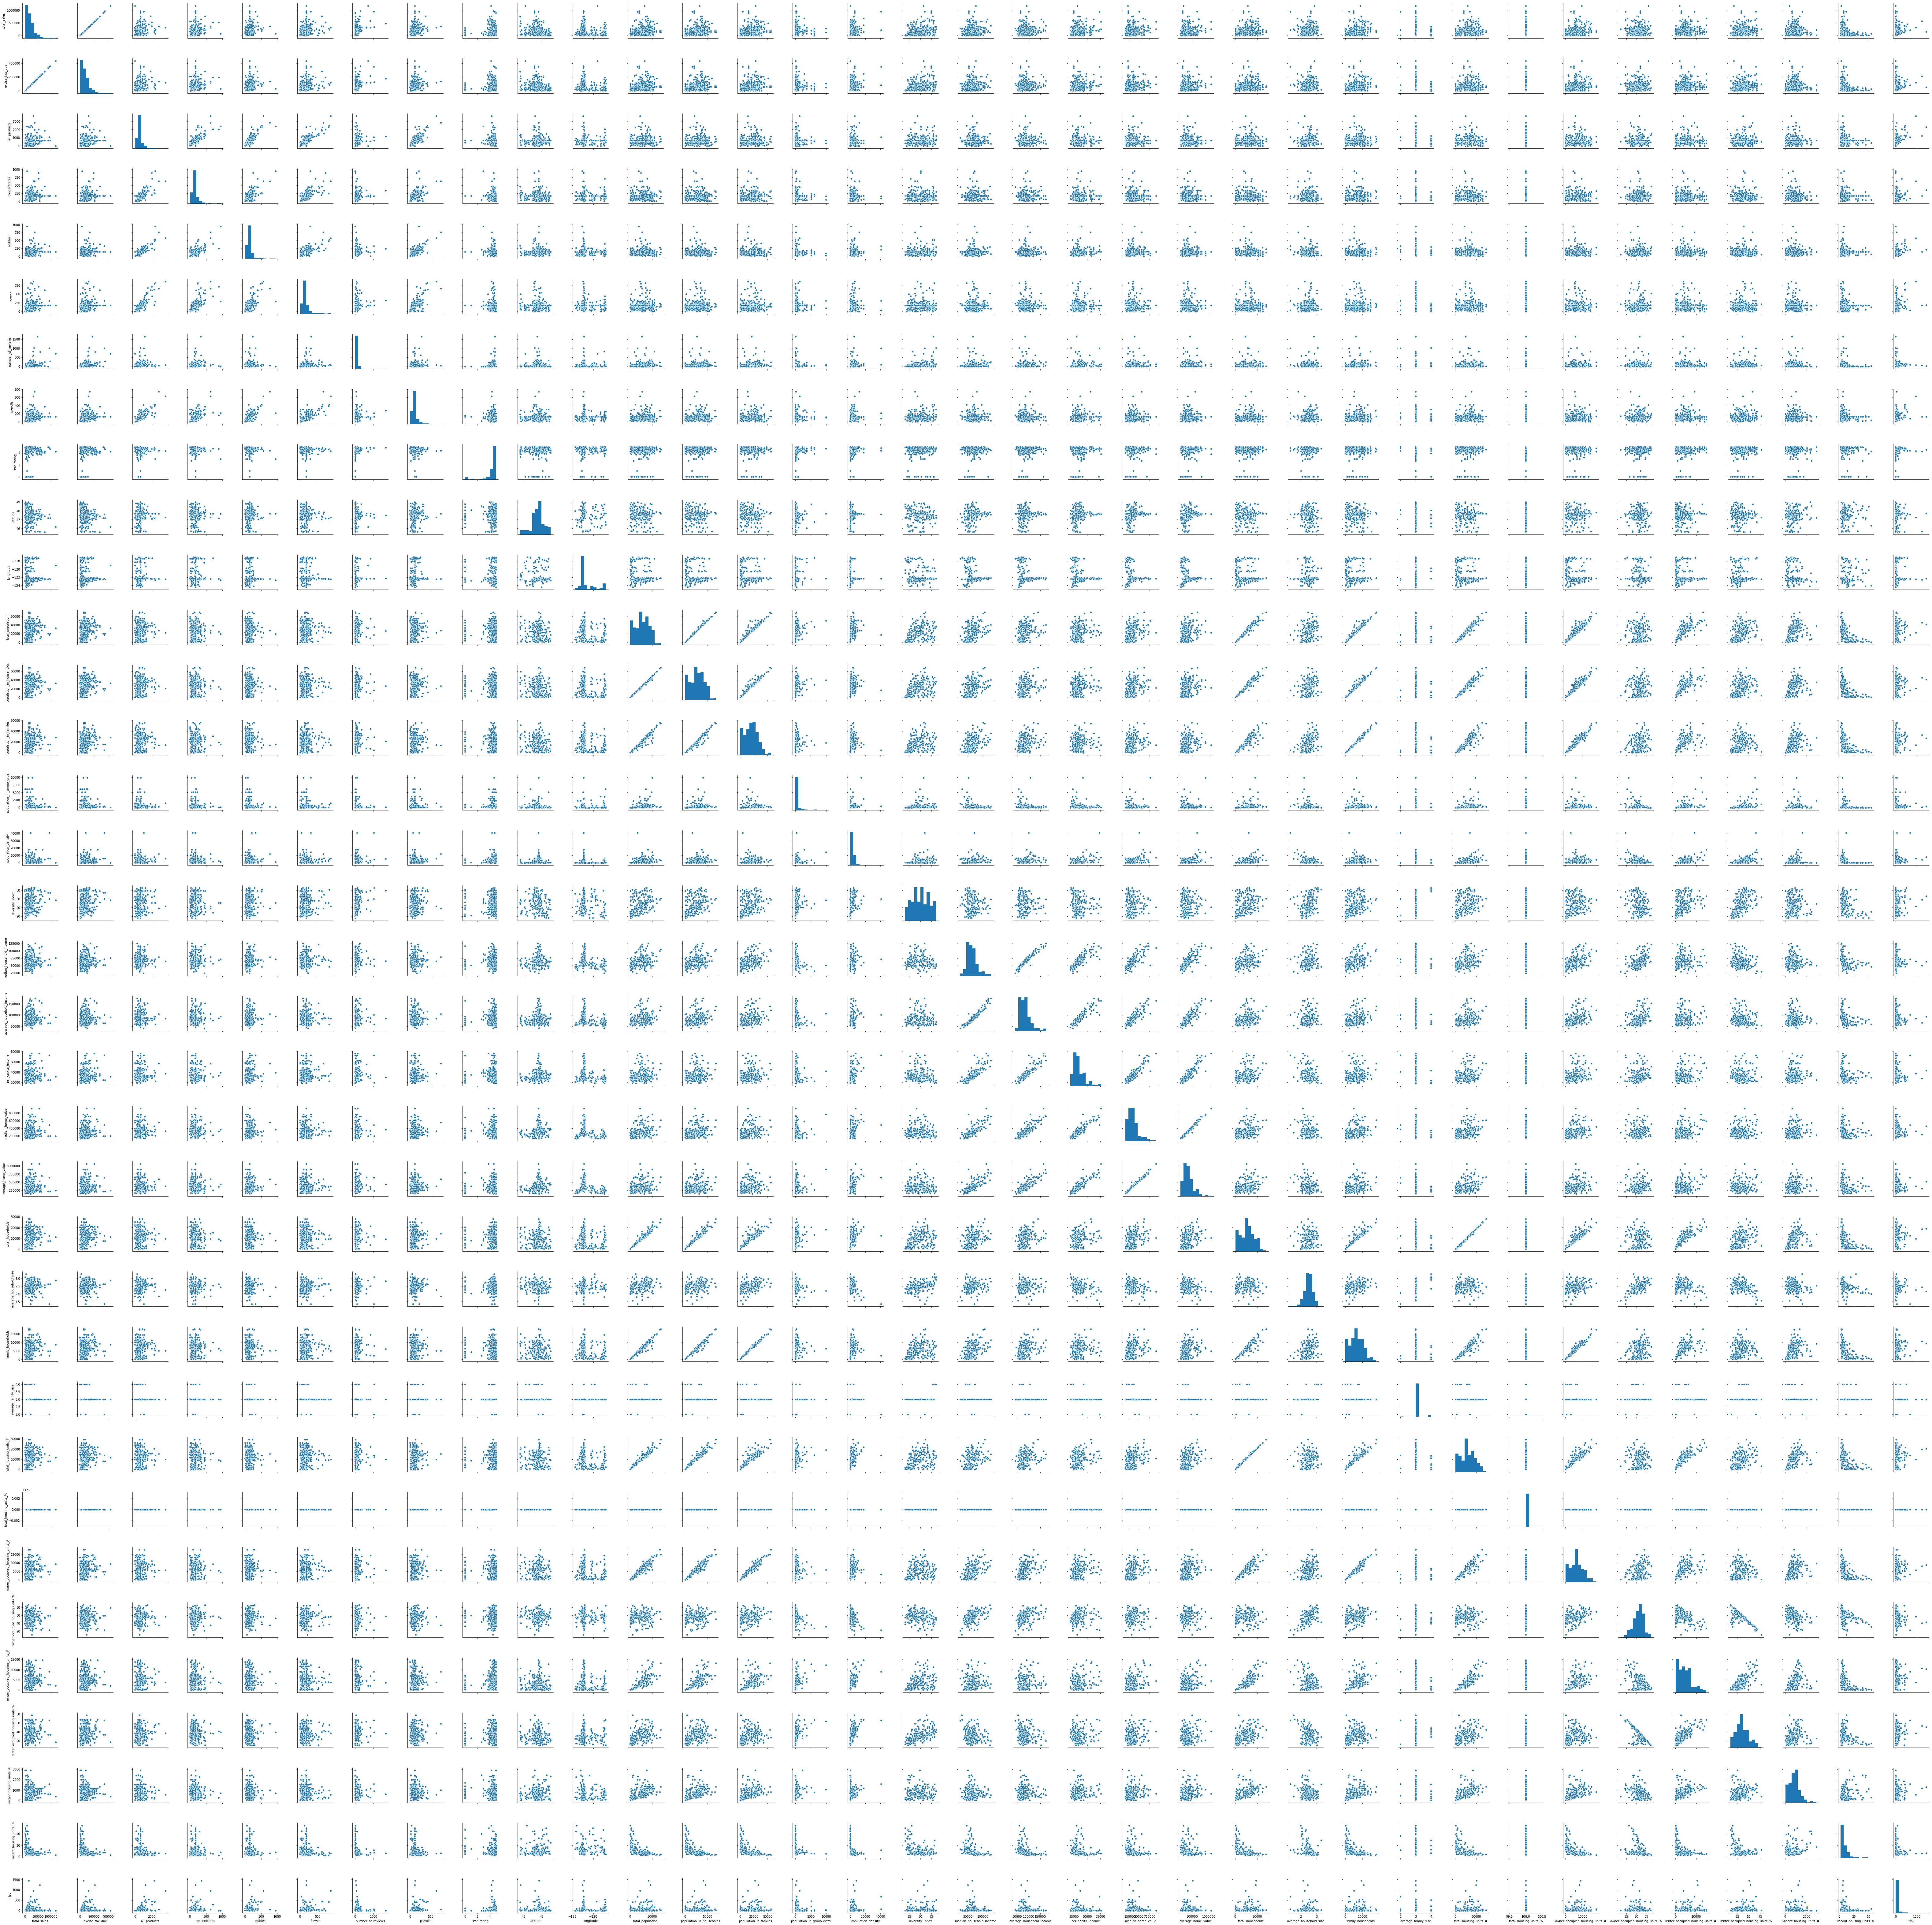

In [276]:
sns.pairplot(newmeric)

*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [375]:
inpath = path['interim'] + filename['int_joined']
outpath = path['processed'] + filename['processed']
data = pd.read_pickle(inpath)

products = ['accessories', 'all_products', 'cartridges', 'concentrates', 
            'edibles', 'flower', 'other', 'prerolls', 'seeds', 'topicals']

# Add flag indicating whether dispensary has menu on Leafly profile
data['leafly_menu'] = data[products].sum(axis=1) > 0

# Lump all low-count Leafly features (along with other) into misc column
counts = data[products].count()
low_counts = [p for p in counts.index if counts[p] < 0.25 * len(data)]
if 'other' not in low_counts:
    low_counts.append('other')
data['misc'] = data[low_counts].sum(axis=1)
drop_cols = low_counts
# data.drop(labels=low_counts, axis=1, inplace=True)

# Categoricals
debit = ['atm', 'debit_cards_accepted']
data['debit_available'] = data[debit].sum(axis=1) > 0
drop_cols += debit
discounts = ['ufcw_discount', 'veteran_discount']
data['discounts'] = data[discounts].sum(axis=1) > 0
drop_cols += discounts

# Fill nans with mean
demo_cols = [
    'all_products', 'concentrates', 'edibles', 'flower', 'prerolls',
    'total_population', 'population_in_households', 'population_in_familes',
    'population_in_group_qrtrs', 'population_density', 'diversity_index',
    'median_household_income', 'average_household_income',
    'per_capita_income', 'median_home_value', 'average_home_value',
    'total_households', 'average_household_size', 'family_households',
    'average_family_size', 'total_housing_units_#', 'total_housing_units_%',
    'owner_occupied_housing_units_#', 'owner_occupied_housing_units_%',
    'renter_occupied_housing_units_#', 'renter_occupied_housing_units_%',
    'vacant_housing_units_#', 'vacant_housing_units_%']
nan_fill = data[demo_cols].mean()
data[demo_cols] = data[demo_cols].fillna(nan_fill)

# Days since last menu update and since license issued
dates = ['reporting_period', 'last_menu_update', 'date_issued']
days = ['days_since_update', 'days_since_license']
data[days[0]] = data[dates[0]].dt.day - data[dates[1]].dt.day
data[days[1]] = data[dates[0]].dt.day - data[dates[2]].dt.day
data[days] = data[days].fillna(data[days].median())

# Drop unused cols
drop_cols += dates
data.drop(labels=drop_cols, axis=1, inplace=True)

In [376]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, The Herbery - Chkalov to Bud Barn
Data columns (total 45 columns):
total_sales                        391 non-null float64
excise_tax_due                     391 non-null float64
privilegestatus                    391 non-null object
ada_accessible                     391 non-null object
all_products                       391 non-null float64
concentrates                       391 non-null float64
edibles                            391 non-null float64
flower                             391 non-null float64
medical                            391 non-null object
number_of_reviews                  391 non-null float64
prerolls                           391 non-null float64
recreational                       391 non-null object
star_rating                        391 non-null float64
storefront                         391 non-null object
latitude                           391 non-null float64
longitude                          391 n

In [372]:
null_cols.median()

all_products    535.0
concentrates    146.0
edibles         109.5
flower          147.5
prerolls         95.5
dtype: float64

In [373]:
null_cols.mean()

all_products    652.847390
concentrates    170.573276
edibles         139.754167
flower          172.268595
prerolls        120.595833
dtype: float64

In [ ]:
## %%writefile ../src/visualization/visualize.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between 
    features.
    """
    # data = load_features('data/processed')
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    pass


*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [223]:
## %%writefile ../src/models/train_model.py

# Imports
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Helper functions

def save_to(item, path):
    """
    
    """
    with open(path, 'wb') as to_write:
        pickle.dump(item, to_write)
    
    return


def split_train_test(data):
    """
    
    """
#     X, y = data.drop('total_sales', axis=1), data['total_sales']

    # Hold out 20% of the data for final testing
    train, test = train_test_split(data, test_size=.2, random_state=69)
    return (train, test)


def load_features(filepath):
    """
    
    """
    data = pd.read_pickle(filepath)
    features = [
        'ada_accessible', 'all_products', 'atm',
        'concentrates', 'debit_cards_accepted', 'edibles', 'flower', 'medical', 
        'number_of_reviews', 'prerolls', 'recreational', 
        'star_rating', 'storefront', 'ufcw_discount', 
        'veteran_discount', 'leafly_menu', 'misc',
        'total_population', 'population_in_households', 'population_in_familes',
        'population_in_group_qrtrs', 'population_density', 'diversity_index',
        'median_household_income', 'average_household_income',
        'per_capita_income', 'median_home_value', 'average_home_value',
        'total_households', 'average_household_size', 'family_households',
        'average_family_size', 'total_housing_units_#', 'total_housing_units_%',
        'owner_occupied_housing_units_#', 'owner_occupied_housing_units_%',
        'renter_occupied_housing_units_#', 'renter_occupied_housing_units_%',
        'vacant_housing_units_#', 'vacant_housing_units_%']
    
    target = ['total_sales']
    cols = features + target
    refined_data = data[cols]
    abs_corrs = refined_data.corr()[target].abs().sort_values(by=target, ascending=False)
    features = list(abs_corrs[:11].drop(target).index)
    cols = features + target
    model_data = refined_data[cols]
    
    return model_data
    
    
def run(rand=10):
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between 
    features.
    """
    path = '../data/processed/'
    filename = {
        'data': 'data.pkl',
        'train': 'train.pkl',
        'test': 'test.pkl'
    }
    target = 'total_sales'
    
    data = load_features(path + filename['data'])
#     print(data.info())
    X, y = data.drop(target, axis=1), data[target]

    # Hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X, y, random_state=rand)
#     save_to(train, path + filename['train'])
#     save_to(test, path + filename['test'])
    
    lm1 = LinearRegression()
    lm1.fit(X, y)
    save_to(lm1, '../models/lm1.pkl')
    return lm1, X, X_test, y, y_test

In [ ]:
## %%writefile ../src/models/predict_model.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between
    features.
    """
    # test_X, test_y = load_test_data('data/processed')
    # trained_model = load_model('models/')
    # predictions = trained_model.predict(test_X)
    # metrics = evaluate(test_y, predictions)
    # save_metrics('reports/')
    pass



_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_

ValueError: color kwarg must have one color per data set. 391 data sets and 1 colors were provided

In [246]:
from sklearn.metrics import mean_squared_error

In [227]:
lm1, X, X_test, y, y_test = run(rand=12)

print('Model Performance\n')
Rs = pd.DataFrame({'R^2': [lm1.score(X, y), lm1.score(X_test, y_test)]})
Rs.index = ['Train', 'Test']
display(Rs)

pd.DataFrame({'Features': list(X.columns), 'Coefficients': list(lm1.coef_)})

Model Performance



R^2
Train  0.312832
Test   0.135620

Features  Coefficients
0                number_of_reviews    452.263982
1               population_density      9.914285
2           vacant_housing_units_%  -2699.820555
3         population_in_households    -41.812238
4                 total_population     11.448264
5            population_in_familes     40.114583
6                 total_households     26.385725
7  renter_occupied_housing_units_%   1587.277945
8            total_housing_units_#      6.079929
9                family_households    -52.732912

Model Performance:



Features  Coefficients
0                number_of_reviews    360.188489
1               population_density      8.811486
2           vacant_housing_units_%  -2809.686046
3         population_in_households    -22.419076
4                 total_population      7.247071
5            population_in_familes     22.784011
6                 total_households      0.621310
7  renter_occupied_housing_units_%   1908.606396
8            total_housing_units_#     11.519387
9                family_households    -27.409941

Train      Test
0   0.261207  0.322990
1   0.291639 -0.305349
2   0.309398  0.162343
3   0.303329  0.149195
4   0.237658  0.302200
5   0.302912  0.181131
6   0.279700  0.269817
7   0.261225  0.309929
8   0.308560  0.083684
9   0.339521 -0.016896
10  0.249964  0.309131
11  0.297712  0.103621
12  0.312832  0.135620
13  0.293319  0.216998
14  0.237300  0.411281
15  0.318612  0.152423
16  0.299326  0.078385
17  0.308584  0.199997
18  0.301531 -0.030599
19  0.291301  0.224656
20  0.330355  0.071266
21  0.291353  0.219717
22  0.290511  0.075367
23  0.298719  0.222473
24  0.289103  0.243996

Text(0, 0.5, 'R^2')

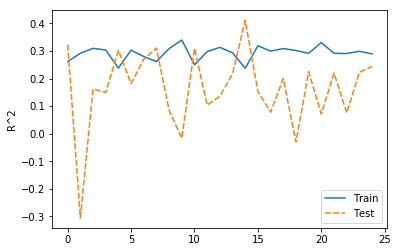

In [265]:
train_r = []
test_r = []

for t in range(25):
    lm1, X, X_test, y, y_test = run(rand=t)
    train_r.append(lm1.score(X, y))
    test_r.append(lm1.score(X_test, y_test))
    y_pred = lm1.predict(X_test)
    
print('Model Performance:\n')
display(pd.DataFrame({'Features': list(X.columns), 'Coefficients': list(lm1.coef_)}))

Rs = pd.DataFrame({'Train': train_r, 'Test': test_r})
display(Rs)

# Rs.plot()
sns.lineplot(data=Rs)
plt.ylabel('R^2')

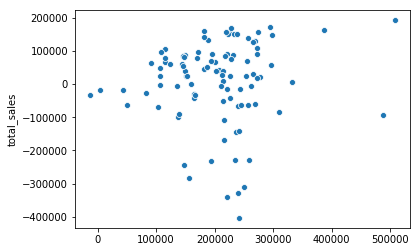

In [266]:
sns.scatterplot(y_pred, y_pred - y_test)

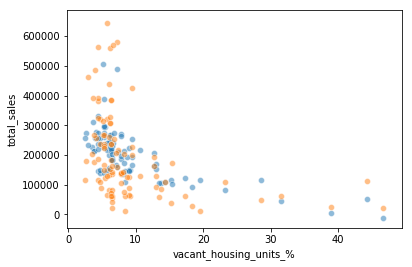

In [256]:
sns.scatterplot(X_test['vacant_housing_units_%'], y_pred, alpha=0.5)
sns.scatterplot(X_test['vacant_housing_units_%'], y_test, alpha=0.5)